In [1]:
import os
import inspect

def getsourcefile(obj):
    if '__code__' in dir(obj):
        return obj.__code__.co_filename
    else:
        return inspect.getsourcefile(obj.__class__)

def emacs(obj):
    os.system("DISPLAY=:10.0 gnome-terminal -e 'emacs -nw "
              +getsourcefile(obj)+"'")

def gedit(obj):
    os.system("DISPLAY=:10.0 gedit "+getsourcefile(obj) +"&")
    
def undecorate(func):
    return func.__closure__[0].cell_contents

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Solving the rbc model

This worksheet demonstrates how to solve the RBC model with the [dolo](http://econforge.github.io/dolo/) library 
and how to generates impulse responses and stochastic simulations from the solution.

- this notebook is distributed with dolo in : ``examples\notebooks\``. The notebook was opened and run from that directory.
- the model file is in : ``examples\global_models\``

First we import the dolo library.

In [3]:
from dolo import *

The RBC model is defined in a [YAML](http://www.yaml.org/spec/1.2/spec.html#Introduction) file which we can read locally or pulled off the web.

In [4]:
filename = 'https://raw.githubusercontent.com/EconForge/dolo/master/examples/models/rbc.yaml'
pcat(filename)

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72


`yaml_import(filename)` reads the YAML file and generates a model object. 

In [5]:
model = yaml_import(filename)

The model file already has values for steady-state variables stated in the calibration section so we can go ahead and check that they are correct by computing the model equations at the steady state.

In [6]:
model.residuals()

OrderedDict([('transition', array([  0.00000000e+00,   2.50466314e-13])), ('arbitrage', array([ -1.01030295e-14,  -3.78141962e-12])), ('auxiliary', array([ -3.28626015e-13,   7.63278329e-17,   4.48352466e-12])), ('value', array([  7.81597009e-14]))])

Printing the model also lets us have a look at all the model equations and check that all residual errors are 0 at the steady-state, but with less display prescision.

In [7]:
print( model ) 


Model object:
------------

- name: "RBC"
- type: "fga"
- file: "https://raw.githubusercontent.com/EconForge/dolo/master/examples/models/rbc.yaml

- residuals:

    transition
        1   : 0.0000 : z = (1-rho)*zbar + rho*z(-1) + e_z
        2   : 0.0000 : k = (1-delta)*k(-1) + i(-1)

    arbitrage
        1   : 0.0000 : 1 = beta*(c/c(1))**(sigma)*(1-delta+rk(1))   | 0 <= i <= inf
        2   : 0.0000 : w - chi*n**eta*c**sigma                  | 0 <= n <= inf

    auxiliary
        1   : 0.0000 : c = z*k**alpha*n**(1-alpha) - i
        2   : 0.0000 : rk = alpha*z*(n/k)**(1-alpha)
        3   : 0.0000 : w = (1-alpha)*z*(k/n)**(alpha)

    value
        1   : 0.0000 : V = log(c) + beta*V(1)




Next we compute a solution to the model using a first order perturbation method (see the source for the [approximate_controls](https://github.com/EconForge/dolo/blob/master/dolo/algos/fg/perturbations.py) function). The result is a decsion rule object. By decision rule we refer to any object is callable and maps states to decisions. This particular decision rule object is a TaylorExpansion (see the source for the [TaylorExpansion](https://github.com/EconForge/dolo/blob/master/dolo/numeric/taylor_expansion.py)  class).

In [8]:
dr_pert = approximate_controls(model, order=1)

To compute a second order approximation use:

```
dr_pert = approximate_controls(model, order=2)
```

We now compute the global solution (see the source for the [time_iteration](https://github.com/EconForge/dolo/blob/master/dolo/algos/fg/time_iteration.py) function).

In [9]:
dr_global = time_iteration(model, pert_order=1, smolyak_order=3)

# plot decision rule

Here we plot optimal investment for different levels of capital (see the source for the [plot_decision_rule](https://github.com/EconForge/dolo/blob/master/dolo/algos/fg/simulations.py) function).

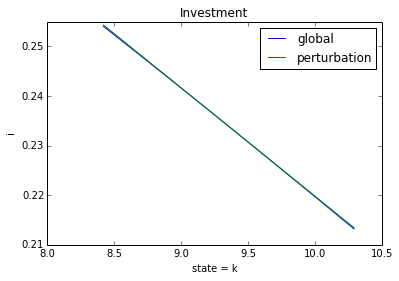

In [10]:
bounds = [dr_global.smin[1], dr_global.smax[1]]
plot_decision_rule(model, dr_global, 'k', 'i', label='global', bounds=bounds)
plot_decision_rule(model, dr_pert, 'k', 'i', label='perturbation', bounds=bounds)
ylabel('i')
title('Investment')
legend()
show()

It is well known that for the RBC model pertubation does very well.

Let us repeat the same exercise for various parameter values for the depreciation rate, $\delta$.

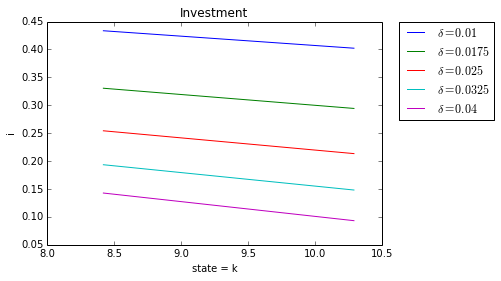

In [11]:
drs = []
delta_values = linspace(0.01, 0.04,5)
for val in delta_values:
    model.set_calibration(delta=val)
    drs.append(approximate_controls(model))
    
for i,dr in enumerate(drs):
    plot_decision_rule(model, dr, 'k', 'i',
                       label='$\delta={}$'.format(delta_values[i]), 
                       bounds=bounds)

ylabel('i')
title('Investment')
legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
show()

We find that more durable capital leads to higher steady state investment and slows the rate of convergence for capital (the slopes are roughly the same, which implies that relative to steady state capital investment responds stronger at higher $\delta$, this in addition to the direct effect of depreciation).

# Use the model to simulate

We will use the deterministic steady-state as a starting point.

In [12]:
s0 = model.calibration['states']
print(str(model.symbols['states'])+'='+str(s0))

['z', 'k']=[ 1.          5.50054432]


We also get the covariance matrix just in case. This is a one shock model so all we have it the variance of $e_z$.

In [13]:
sigma2_ez = model.covariances
sigma2_ez

array([[ 0.000256]])

## Impulse response functions

Consider a 10% shock on productivity.

In [14]:
s1 = s0.copy()
s1[0] *= 1.1
print(str(model.symbols['states'])+'='+str(s1))

['z', 'k']=[ 1.1         5.50054432]


The `simulate` function is used both to trace impulse response functions and compute stochastic simulations. Choosing `n_exp>=1`, will result in that many "stochastic" simulations. With `n_exp = 0`, we get one single simulation without any stochastic shock (see the source for the [simulate](https://github.com/EconForge/dolo/blob/master/dolo/algos/fg/simulations.py) function). 
The output is a panda table of size $H \times n_v$ where $n_v$ is the number of variables in the model and $H$ the number of dates.

In [15]:
irf = simulate(model, dr_global, s1, n_exp=0, horizon=40 )
print(irf.__class__)
print(irf.shape)


<class 'pandas.core.frame.DataFrame'>
(40, 7)


Let us plot the response of consumption and investment.

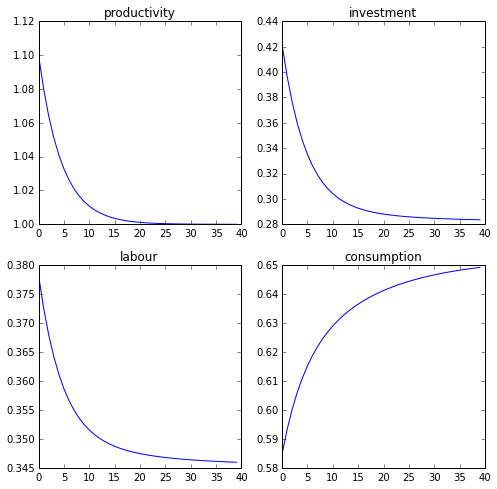

In [16]:
figsize(8,8)
subplot(221)
plot(irf['z'], label='productivity')
subplot(222)
plot(irf['i'], label='investment')
subplot(223)
plot(irf['n'], label='labour')
subplot(224)
plot(irf['c'], label='consumption')

subplot(221)
title('productivity')
subplot(222)
title('investment')
subplot(223)
title('labour')
subplot(224)
title('consumption')

Note that the plotting is made using the wonderful [matplotlib](http://matplotlib.org/users/pyplot_tutorial.html) library. Read the online documetation to learn how to [customize](http://matplotlib.org/users/beginner.html) the plots to your needs (e.g., using [latex](http://matplotlib.org/users/usetex.html) in annotations). If instead you would like to produce charts in Matlab, you can easily export the impulse response functions to a `.mat` file.

In [17]:
irf_array = array( irf )
import scipy.io
scipy.io.savemat("export.mat", {'table': irf_array} )

## Stochastic simulations

Now we run 1000 random simulations the result is an array of size $H\times n_{exp} \times n_v$ where 
- $H$ the number of dates
- $n_{exp}$ the number of simulations
- $n_v$ is the number of variables


In [18]:
sim = simulate(model, dr_global, s0, n_exp=1000, horizon=40 )
print(sim.shape)

(40, 1000, 7)


In [19]:
model.variables

('z', 'k', 'i', 'n', 'c', 'rk', 'w')

We plot the responses of consumption, investment and labour to the stochastic path of productivity.

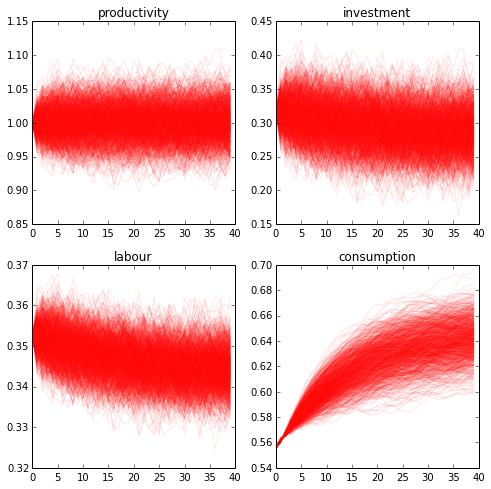

In [20]:
i_z = model.variables.index('z')
i_i = model.variables.index('i')
i_n = model.variables.index('n')
i_c = model.variables.index('c')
figsize(8,8)
for i in range(1000):
    subplot(221)
    plot(sim[:, i, i_z], color='red', alpha=0.1)
    subplot(222)
    plot(sim[:, i, i_i], color='red', alpha=0.1)
    subplot(223)
    plot(sim[:, i, i_n], color='red', alpha=0.1)
    subplot(224)
    plot(sim[:, i, i_c], color='red', alpha=0.1)

subplot(221)
title('productivity')
subplot(222)
title('investment')
subplot(223)
title('labour')
subplot(224)
title('consumption')

In [21]:
# We can also make some statistics
dsim = log(sim[1:,:,:]/sim[:-1,:,:,]) # compute growth rates
volat = dsim.std(axis=0) # compute volatility of growth rates for each simulation
table = column_stack([
    volat.mean(axis=0),
    volat.std(axis=0)
])
display(table)
print('First column contains the standard deviations of growth rates.')
print('Second column contains the confidence intervals.')

array([[ 0.01667413,  0.00197561],
       [ 0.00567924,  0.00107556],
       [ 0.06565494,  0.0082152 ],
       [ 0.00989158,  0.00117758],
       [ 0.004317  ,  0.00062935],
       [ 0.0244212 ,  0.00287629],
       [ 0.01322721,  0.0015262 ]])

First column contains the standard deviations of growth rates.
Second column contains the confidence intervals.


We can use the [pandas](http://pandas.pydata.org/pandas-docs/stable/10min.html) library to present the results

In [22]:
model.variables

('z', 'k', 'i', 'n', 'c', 'rk', 'w')

In [23]:
import pandas
df = pandas.DataFrame(table, index=model.variables, columns=['std. deviations','confidence intervals'])
df

,std. deviations,confidence intervals
z,0.016674,0.001976
k,0.005679,0.001076
i,0.065655,0.008215
n,0.009892,0.001178
c,0.004317,0.000629
rk,0.024421,0.002876
w,0.013227,0.001526


In [24]:
# export to matlab
# - stochastic simulations are already stored as an array
# - the dataframe needs to be converted
import scipy.io
scipy.io.savemat("export2.mat", {'stoch_sim': sim, 'stats': array(df)} )

# Error measures

In [25]:
from dolo.algos.fg.accuracy import omega

In [26]:
print("Perturbation solution")
err_pert = omega(model, dr)
err_pert

Perturbation solution


Euler Errors:
- max_errors     : [ 0.00103215  0.00514183]
- ergodic        : [ 0.00021611  0.00071471]


In [27]:
print("Global solution")
omega(model, dr_global)

Global solution


Euler Errors:
- max_errors     : [ 0.00737785  0.06639994]
- ergodic        : [ 0.00657547  0.06504656]


In [28]:
# the error reports contain more informations:
err_pert.keys()

['domain', 'errors', 'densities', 'ergodic', 'max_errors', 'bounds']

In [29]:
a = err_pert['domain'].a
b = err_pert['domain'].b
orders = err_pert['domain'].orders
errors = err_pert['errors'].reshape( orders.tolist()+[-1] )



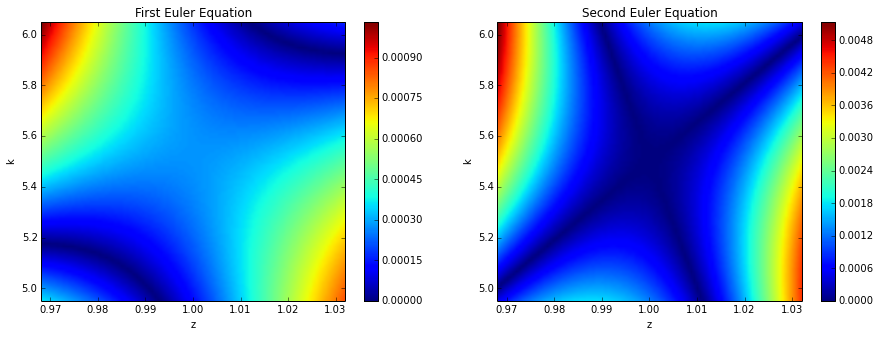

In [30]:
figure(figsize=(15,5))
subplot(121)
imshow(errors[:,:,0], origin='lower', extent=( a[0], b[0], a[1], b[1]), aspect='auto')
xlabel('z')
ylabel('k')
colorbar()
title("First Euler Equation")
subplot(122)
imshow(errors[:,:,1], origin='lower', extent=( a[0], b[0], a[1], b[1]), aspect='auto')
colorbar()
xlabel('z')
ylabel('k')
title("Second Euler Equation")